# Uplift моделирование на данных компании MegaFon. Улучшение модели

Набор данных предоставлен компанией "МегаФон" в рамках соревнования [MegaFon Uplift Competition](https://ods.ai/competitions/megafon-df21-comp), проведенном в мае 2021 года.

**Описание данных**

* `id` (int): client id
* `treatment_group` (str): флаг treatment/control группы
* `X_1...X_50` (float): анонимированные признаки
* `conversion` (binary): target (целевой признак, факт совершения целевого действия)

In [ ]:
import sys

# установим библиотеку uplift scikit-uplift и другие библиотеки
!pip install scikit-uplift lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [ ]:
import sklift
from sklift.datasets import fetch_megafon
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, cross_validate, cross_val_score

from sklift.models import SoloModel
from sklift.models import TwoModels
from sklift.models import ClassTransformation
import lightgbm
from lightgbm import LGBMClassifier

from sklift.metrics import make_uplift_scorer, uplift_at_k, uplift_by_percentile, weighted_average_uplift, uplift_auc_score, qini_auc_score, average_squared_deviation


# from sklift.viz import plot_uplift_by_percentile
# from sklift.viz import plot_qini_curve, plot_uplift_curve
# from sklift.viz import plot_uplift_preds
from catboost import CatBoostClassifier


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

seed=42

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Загрузка данных и изучение данных

Датасет можно загрузить из модуля `sklift.datasets`, используя функцию `fetch_megafon`.

In [ ]:
# returns sklearn Bunch object
# with data, target, treatment keys
# data features (pd.DataFrame), target (pd.Series), treatment (pd.Series) values

df = fetch_megafon()

Megafon dataset:   0%|          | 0.00/276M [00:00<?, ?iB/s]

In [ ]:
print(f"Тип загруженных данных: {type(df)}\n")
print(f"Размерность датасета признаков features: {df['data'].shape}")
print(f"Размерность вектора target: {df['target'].shape}")
print(f"Размерность вектора treatment: {df['treatment'].shape}")

Тип загруженных данных: <class 'sklearn.utils._bunch.Bunch'>

Размерность датасета признаков features: (600000, 50)
Размерность вектора target: (600000,)
Размерность вектора treatment: (600000,)


Изучим набор признаков.

In [ ]:
# первые 5 строк
df['data'].head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,283.544750,-3.297557,74.491728,11.674656,-4.852843,99.324038,159.686346,-5.830570,-4.554391,-75.704888,-4.540720,107.891557,-0.592276,0.513937,-3.415607,-7.454581,-38.519996,-116.186909,18.253466,0.775597,-66.833169,121.204278,-58.588803,0.266334,0.758562,-13.254177,200.715580,77.227063,-230.591020,-3.023398,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,114.382486,10.277246,132.852421,-14.088731,82.011396,-19.290410,-155.851825,3.904401,26.194543,87.908221,115.714068,-179.564296,-1.202563,1.827663,87.042091,6.771393,12.481973,304.514135,3.618649,-0.422986,76.520982,67.402922,-407.896510,-1.269765,-34.027547,-91.572702,61.215866,-80.652713,-782.791784,-33.541388,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,628.310139,-7.714403,-4.863992,-41.638770,187.244122,16.716381,103.805977,15.248096,-7.963610,-18.581579,247.603883,-60.794763,-0.707689,-0.293637,186.251855,4.644561,-13.456976,52.765776,-95.096983,-2.191094,41.936533,17.929746,-243.263646,7.630227,-27.235726,38.757461,168.534929,94.979240,-177.641632,-40.559792,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,374.208539,-5.197953,-16.972788,-20.513819,26.733826,-5.051170,266.620852,-1.003867,5.644895,101.563496,24.222458,15.445679,-0.193439,-0.537621,18.220545,-19.826745,-9.969067,-176.056848,-34.994979,-0.169379,20.194249,97.909989,41.396933,-4.572652,73.594603,59.882086,-18.703877,109.139592,-4.272029,18.375161,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,-555.119130,14.632472,100.997894,-10.130204,52.278128,-6.223072,-91.566718,24.962987,16.902873,-125.359051,77.880711,65.763350,-0.250273,0.470302,58.583197,24.301061,7.895425,64.681136,0.208348,1.215403,-32.063615,1.182104,-15.530264,9.247841,-40.267539,27.330542,-78.737771,-79.762654,-101.123230,-30.324588,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858


In [ ]:
df['data'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 50 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X_1     600000 non-null  float64
 1   X_2     600000 non-null  float64
 2   X_3     600000 non-null  float64
 3   X_4     600000 non-null  float64
 4   X_5     600000 non-null  float64
 5   X_6     600000 non-null  float64
 6   X_7     600000 non-null  float64
 7   X_8     600000 non-null  float64
 8   X_9     600000 non-null  float64
 9   X_10    600000 non-null  float64
 10  X_11    600000 non-null  float64
 11  X_12    600000 non-null  float64
 12  X_13    600000 non-null  float64
 13  X_14    600000 non-null  float64
 14  X_15    600000 non-null  float64
 15  X_16    600000 non-null  float64
 16  X_17    600000 non-null  float64
 17  X_18    600000 non-null  float64
 18  X_19    600000 non-null  float64
 19  X_20    600000 non-null  float64
 20  X_21    600000 non-null  float64
 21  X_22    60

In [ ]:
# Вычислим числовые характеристики признаков
df['data'].describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,-3.758503,0.000405,0.356208,-1.004378,3.376919,-6.396371,-2.253712,-6.432606,-0.061507,-1.659301,19.093492,-0.093886,-0.002533,-2.463280,13.161988,7.063375,6.858253,-0.020896,-0.985809,-1.114770,14.835209,-9.909231,0.002470,-0.002707,11.159296,0.024798,-0.978981,4.599121,-6.263516,0.000554,2.704003,0.027546,-6.514740,-0.005655,3.002134,5.325791,7.739900,-4.721989,-9.206852,2.728692,6.882868,-6.632834,8.454493,0.001296,0.007967,-0.000966,-22.259600,-5.759041,6.241130,-1.176456
std,54.881882,0.999419,31.804123,45.291429,53.397644,140.873734,59.810396,74.840857,44.912292,199.625148,455.894665,11.295157,56.797326,39.922589,114.277207,77.628539,190.951808,11.476030,26.239683,72.371005,138.517373,160.879307,0.999777,1.000431,104.195126,28.332643,13.729246,142.981246,75.071084,1.000134,51.108902,107.851987,153.130771,6.964937,47.529482,70.700510,134.675174,131.789351,197.493595,39.501936,163.776538,137.025868,262.840194,1.000368,71.553713,0.999902,500.900364,130.952113,141.211999,21.363662
min,-271.659497,-4.372119,-148.870768,-244.446728,-302.574049,-683.126343,-322.731683,-506.202937,-218.466369,-920.347783,-2289.294108,-52.074964,-313.255431,-195.457350,-636.553079,-533.404670,-913.011610,-55.140610,-125.733156,-330.755792,-770.324798,-774.266979,-4.545333,-4.708793,-579.451426,-126.515623,-64.651485,-732.116727,-399.414460,-4.553086,-346.728398,-515.521884,-743.800243,-32.088261,-251.277376,-348.076864,-668.793144,-700.110808,-1016.301591,-179.589370,-810.842593,-633.575178,-1345.838757,-4.756720,-360.713742,-4.516004,-2506.960013,-687.526201,-702.184241,-98.094323
25%,-40.693313,-0.673108,-20.758308,-30.644608,-31.865404,-100.762161,-42.313674,-54.840796,-30.327330,-134.565241,-286.292508,-7.613948,-38.401625,-29.205585,-62.727814,-36.893267,-121.868113,-7.752689,-18.645383,-50.050451,-77.058591,-117.394644,-0.671963,-0.676781,-57.964784,-19.118055,-10.247693,-91.190920,-56.366783,-0.674265,-30.975631,-72.732677,-109.888686,-4.711524,-26.971012,-42.250017,-82.922581,-93.661192,-142.413854,-23.338528,-102.658380,-99.033996,-167.634846,-0.673780,-48.250836,-0.675549,-357.547278,-93.163915,-88.803657,-15.580688
50%,-3.954771,0.000915,0.372583,-0.585368,3.720738,-6.357443,-2.263690,-6.416419,-0.103742,-1.628897,17.651122,-0.092166,-0.011893,-2.438805,13.426780,6.988854,6.639970,-0.030727,-1.007271,-1.084433,15.207025,-9.837197,0.001802,-0.003722,11.438983,0.023834,-0.946478,4.772537,-6.364402,-0.000372,2.732262,0.114877,-6.661874,-0.000436,2.966662,5.500324,7.516796,-4.835168,-9.003721,2.779691,7.190600,-6.784760,8.773280,0.001639,0.045537,-0.002251,-20.695017,-5.774627,6.286783,-1.199895
75%,33.174835,0.673056,21.495530,29.027860,38.988940,88.159514,37.709780,41.962767,30.144501,130.948487,324.226048,7.409305,38.291691,24.248160,89.130548,50.993029,135.756702,7.731675,16.690977,47.694238,106.788310,97.891879,0.677217,0.671145,80.327985,19.116412,8.309784,100.845315,43.792144,0.675415,36.369149,72.890914,96.255945,4.690724,32.898811,52.905711,98.388563,84.208344,124.149483,28.739188,116.755600,85.6

###  Изучим баланс классов target и treatment

In [ ]:
df['treatment'].value_counts(normalize = True)

,proportion
treatment_group,
treatment,0.500613
control,0.499387


In [ ]:
df['target'].value_counts(normalize = True)


,proportion
conversion,
0,0.79581
1,0.20419


Оценим долю конверсии в каждой группе (treatment/control)

In [ ]:
pd.crosstab(df['treatment'], df['target'], normalize='index')#.reset_index()

conversion,0,1
treatment_group,,
0,0.820600,0.179400
1,0.771081,0.228919


Видим дисбаланс в группах

### Подготовка данных для обучения моделей uplift

Преобразуем `treatment` в значения 0 и 1 в зависимости от того, в какую группу попал пользователь.

In [ ]:
df['treatment'].replace(['treatment', 'control'], [1,0], inplace = True)
df['treatment'].value_counts()

,count
treatment_group,
1,300368
0,299632


В задаче бинарной классификации при дисбалансе классов мы используем стратифицированное разбиение данных по столбцу `target`. В задаче uplift дисбаланс должен быть учтен в каждой из групп (`treatment`, `control`). Поэтому сформируем столбец `stratify_cols` из двух столбцов: `treatment` и `target` и разделим данные на обучающую и тестовую выборки в пропорции 4:1.

In [ ]:
stratify_cols = pd.concat([df['treatment'],df['target']], axis=1)

X_train, X_test, treatment_train, treatment_test, y_train, y_test = train_test_split(
    df['data'],
    df['treatment'],
    df['target'],
    stratify=stratify_cols,
    test_size=0.2,
    random_state=seed
)

print(f"Размерность обучающего набора: {X_train.shape}")
print(f"Размерность тестовой выборки: {X_test.shape}")

Размерность обучающего набора: (480000, 50)
Размерность тестовой выборки: (120000, 50)


In [ ]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

In [ ]:
# Создадим оценщик для проведения кросс-валидации
uplift_scorer = make_uplift_scorer("qini_auc_score",treatment_train)

In [ ]:
# Для сохранения пропорций при проведении кросс-валидации будем использовать стратифицированные подвыборки
cv_gen = StratifiedShuffleSplit(
    n_splits=3,
    random_state=seed
)

## Построение моделей

### Одна модель с признаком коммуникации

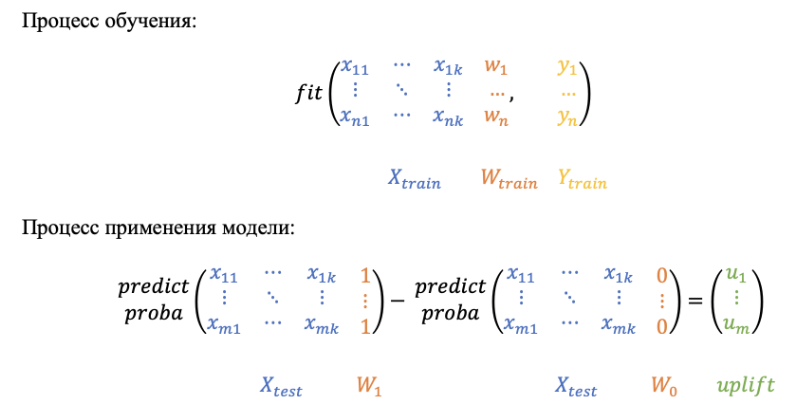

In [ ]:
# Проведем обучение с кросс-валидацией базовой модели
estimator = LGBMClassifier(random_state=seed, n_jobs=-1)
s_model = SoloModel(estimator)

cross_validate(s_model,
               X=X_train,
               y=y_train,
               scoring=uplift_scorer,
               return_estimator=True,
               cv=cv_gen,
               n_jobs=-1,
               fit_params={'treatment': treatment_train}
)


{'fit_time': array([91.59610844, 94.57223916, 19.07446599]),
 'score_time': array([0.92668986, 1.06300974, 0.56556511]),
 'estimator': [SoloModel(estimator=LGBMClassifier(n_jobs=-1, random_state=42)),
  SoloModel(estimator=LGBMClassifier(n_jobs=-1, random_state=42)),
  SoloModel(estimator=LGBMClassifier(n_jobs=-1, random_state=42))],
 'test_score': array([0.22895519, 0.22294613, 0.22625875])}

Получили базовые характеристики на валидационной выборке. Попробуем улучшить модель. Для этого проведем кросс-валидацию с перебором гиперпараметров по сетке GridSearchCV

In [ ]:
grid_params = {
    'estimator__learning_rate': [ 0.2],
    'estimator__max_depth': range(5, 7),
    'estimator__n_estimators': range(200, 300, 50)
}

grid_search = GridSearchCV(s_model,
                           param_grid=grid_params,
                           scoring=uplift_scorer,
                           n_jobs=-1,
                           cv=cv_gen,
                           return_train_score=True
                          )

grid_search = grid_search.fit(
    X=X_train,
    y=y_train,
    treatment=treatment_train
)

[LightGBM] [Info] Number of positive: 98011, number of negative: 381989
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.286035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12752
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204190 -> initscore=-1.360312
[LightGBM] [Info] Start training from score -1.360312


In [ ]:
print(f"Best qini score: {grid_search.best_score_:.4f}")
print(f"Best params: {grid_search.best_params_}")

Best qini score: 0.2347
Best params: {'estimator__learning_rate': 0.2, 'estimator__max_depth': 6, 'estimator__n_estimators': 250}


#### Метрики на тестовой выборке

In [ ]:
s_model = SoloModel(LGBMClassifier(random_state=seed, n_jobs=-1,learning_rate=0.2,max_depth=6,n_estimators=250 ))
s_model.fit(X_train, y_train, treatment_train)
s_uplift = s_model.predict(X_test)

[LightGBM] [Info] Number of positive: 98011, number of negative: 381989
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.549973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12752
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204190 -> initscore=-1.360312
[LightGBM] [Info] Start training from score -1.360312


In [ ]:
#s_uplift = grid_search.best_estimator_.predict(X_test)
# weighted average uplift
uplift_full_data = weighted_average_uplift(y_test, s_uplift, treatment_test, bins=10)
print(f"average uplift на тестовой выборке: {uplift_full_data:.4f}")

average uplift на тестовой выборке: 0.0497


Вычислим `uplift@k`

* strategy='overall' - сортирует по uplift в treatment и control группах вместе взятых

In [ ]:
sm_score_overall = uplift_at_k(y_true=y_test, uplift=s_uplift, treatment=treatment_test, strategy='overall', k=0.3)
print(f'uplift@30% overall {sm_score_overall}')
sm_score_by_group = uplift_at_k(y_true=y_test, uplift=s_uplift, treatment=treatment_test, strategy='by_group', k=0.3)
print(f'uplift@30% overall {sm_score_by_group}')
models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score_by_group)



uplift@30% overall 0.21542148527317181
uplift@30% overall 0.21535170315785093


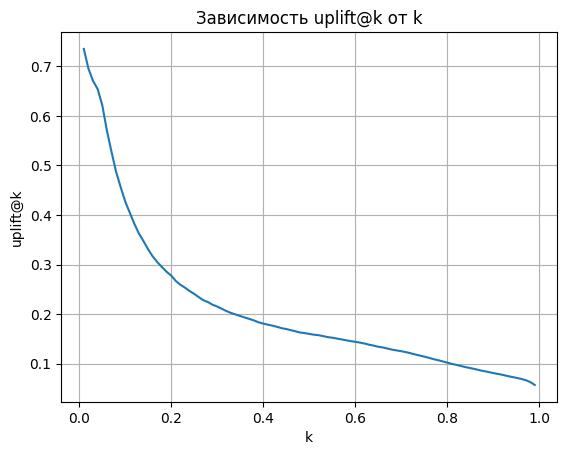

In [ ]:
values_uplift_k_solo = []
values_k = []
for k in np.arange(0.01,1,0.01):
  values_uplift_k_solo.append(uplift_at_k(y_test, s_uplift, treatment_test, strategy='overall', k=k))
  values_k.append(k)

plt.plot(values_k, values_uplift_k_solo)
plt.title('Зависимость uplift@k от k')
plt.xlabel('k')
plt.ylabel('uplift@k')
plt.grid()
plt.show()

In [ ]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, s_uplift, treatment_test)
print(f"Qini coefficient на тестовой выборке: {auqc:.4f}")

Qini coefficient на тестовой выборке: 0.2367


In [ ]:
# AUUC = area under Uplift curve
auuc = uplift_auc_score(y_test, s_uplift, treatment_test)
print(f"Uplift coefficient на тестовой выборке: {auuc:.4f}")

Uplift coefficient на тестовой выборке: 0.1634


In [ ]:
# uplift_by_percentile
up_perc = uplift_by_percentile(y_test, s_uplift, treatment_test,
                     strategy='overall',
                     total=False, std=True, bins=10).reset_index()
up_perc

,percentile,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
0,0-10,5985,6015,0.575940,0.148628,0.427311,0.006388,0.004587,0.007864
1,10-20,5984,6016,0.271390,0.143118,0.128272,0.005748,0.004515,0.007310
2,20-30,5986,6014,0.228700,0.138011,0.090689,0.005428,0.004448,0.007018
3,30-40,5984,6016,0.213904,0.136137,0.077767,0.005301,0.004421,0.006903
4,40-50,6089,5911,0.205945,0.127390,0.078556,0.005182,0.004337,0.006757
5,50-60,5985,6015,0.203509,0.138986,0.064523,0.005204,0.004460,0.006854
6,60-70,6034,5966,0.179649,0.167616,0.012032,0.004942,0.004836,0.006914
7,70-80,5996,6004,0.148432,0.208528,-0.060095,0.004591,0.005243,0.006969
8,80-90,6045,5955,0.096443,0.182200,-0.085756,0.003797,0.005002,0.006280
9,90-100,5985,6015,0.167586,0.402494,-0.234908,0.004828,0.006323,0.007956


Визуализируем результаты таблицы uplift_by_percentile

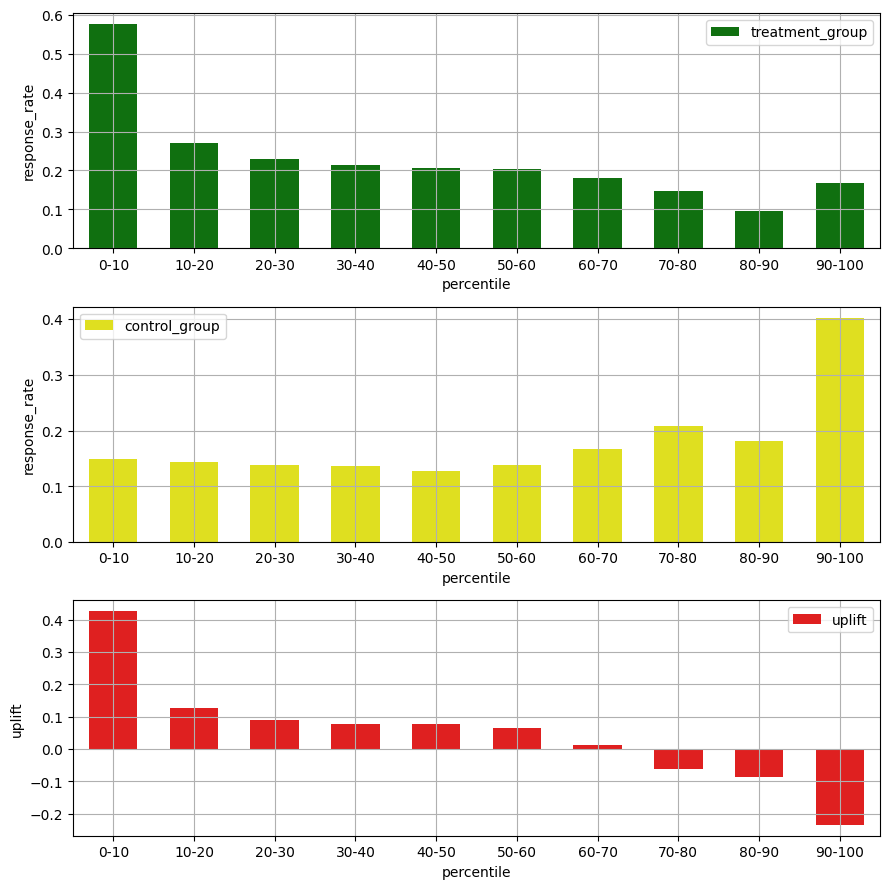

In [ ]:
plt.figure(figsize = (9,9))
plt.subplot(311)
sns.barplot(data = up_perc, x='percentile', y='response_rate_treatment', label = 'treatment_group', color = 'g', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('response_rate')
plt.grid()
plt.legend(loc = 'best')

plt.subplot(312)
sns.barplot(data = up_perc, x='percentile', y='response_rate_control', label = 'control_group', color = 'yellow', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('response_rate')
plt.grid()
plt.legend(loc = 'best')
plt.subplot(313)
sns.barplot(data = up_perc, x='percentile', y='uplift', label = 'uplift', color = 'r', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('uplift')
plt.grid()
plt.legend(loc = 'best')
plt.tight_layout()


In [ ]:
# with ideal Qini curve (red line)
# perfect=True

#fig, ax_roc = plt.subplots(1, 1)
#plot_qini_curve(y_val, s_uplift, treatment_val, name='Solo model', random=True, perfect=True, ax=ax_roc);

# Трансформация классов

In [ ]:
estimator=CatBoostClassifier(verbose =100, thread_count=1, random_state=seed)
ct_model = ClassTransformation(estimator)
cross_validate(ct_model,
               X=X_train,
               y=y_train,
               scoring=uplift_scorer,
               return_estimator=True,
               cv=cv_gen,
               n_jobs=-1,
               fit_params={'treatment': treatment_train}
)

{'fit_time': array([338.47760201, 336.98202825, 193.59044194]),
 'score_time': array([0.39652443, 0.45134115, 0.16308832]),
 'estimator': [ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x7d841cc827a0>),
  ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x7d841cc809a0>),
  ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x7d842d6f4d00>)],
 'test_score': array([0.22555534, 0.21550846, 0.22287552])}

In [ ]:
grid_params = {
    'estimator__learning_rate': [ 0.1],
    'estimator__depth': range(7, 8),
    'estimator__iterations': [200]
}

grid_search = GridSearchCV(ct_model,
                           param_grid=grid_params,
                           scoring=uplift_scorer,
                           n_jobs=-1,
                           cv=cv_gen,
                           return_train_score=True
                          )

grid_search = grid_search.fit(
    X=X_train,
    y=y_train,
    treatment=treatment_train
)

0:	learn: 0.6923902	total: 351ms	remaining: 1m 9s
100:	learn: 0.6755184	total: 29.2s	remaining: 28.6s
199:	learn: 0.6703622	total: 53.9s	remaining: 0us


In [ ]:
print(f"Best qini score: {grid_search.best_score_:.4f}")
print(f"Best params: {grid_search.best_params_}")

Best qini score: 0.2327
Best params: {'estimator__depth': 7, 'estimator__iterations': 200, 'estimator__learning_rate': 0.1}


In [ ]:
ct_model = ClassTransformation(CatBoostClassifier(verbose =100, thread_count=1, random_state=seed, depth=7, iterations=200, learning_rate=0.1))
ct_model = ct_model.fit(X_train, y_train, treatment_train, estimator_fit_params={'plot': True})

ct_uplift = ct_model.predict(X_test)
print(ct_uplift)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6923902	total: 271ms	remaining: 54s
100:	learn: 0.6755184	total: 25.8s	remaining: 25.3s
199:	learn: 0.6703622	total: 55.2s	remaining: 0us
[ 0.12202661 -0.12591936 -0.01329482 ...  0.03538137  0.02600004
  0.05686493]


In [ ]:
ct_uplift = grid_search.best_estimator_.predict(X_test)

# weighted average uplift
uplift_full_data = weighted_average_uplift(y_test, ct_uplift, treatment_test, bins=10)
print(f"average uplift на тестовой выборке: {uplift_full_data:.4f}")

average uplift на тестовой выборке: 0.0496


In [ ]:
ct_score_overall = uplift_at_k(y_true=y_test, uplift=ct_uplift, treatment=treatment_test, strategy='overall', k=0.3)
print(f'uplift@30% overall {ct_score_overall}')
ct_score_by_group = uplift_at_k(y_true=y_test, uplift=ct_uplift, treatment=treatment_test, strategy='overall', k=0.3)
print(f'uplift@30% overall {ct_score_by_group}')
models_results['approach'].append('ClassTransformationModel')
models_results['uplift@30%'].append(ct_score_by_group)

uplift@30% overall 0.21808446363606318
uplift@30% overall 0.21808446363606318


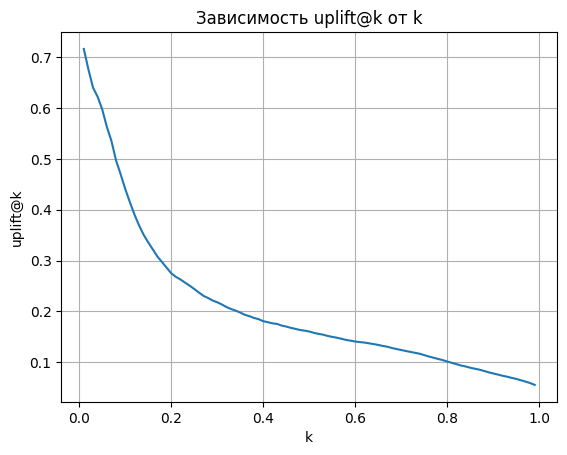

In [ ]:
values_uplift_k_solo = []
values_k = []
for k in np.arange(0.01,1,0.01):
  values_uplift_k_solo.append(uplift_at_k(y_test, ct_uplift, treatment_test, strategy='overall', k=k))
  values_k.append(k)

plt.plot(values_k, values_uplift_k_solo)
plt.title('Зависимость uplift@k от k')
plt.xlabel('k')
plt.ylabel('uplift@k')
plt.grid()
plt.show()

In [ ]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, ct_uplift, treatment_test)
print(f"Qini coefficient на тестовой выборке: {auqc:.4f}")

Qini coefficient на тестовой выборке: 0.2339


In [ ]:
# AUUC = area under Uplift curve
auuc = uplift_auc_score(y_test, ct_uplift, treatment_test)
print(f"Uplift coefficient на тестовой выборке: {auuc:.4f}")

Uplift coefficient на тестовой выборке: 0.1614


In [ ]:
# uplift_by_percentile
up_perc = uplift_by_percentile(y_test, ct_uplift, treatment_test,
                     strategy='overall',
                     total=False, std=True, bins=10).reset_index()
up_perc

,percentile,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
0,0-10,5921,6079,0.583347,0.142458,0.440890,0.006407,0.004483,0.007820
1,10-20,6028,5972,0.238553,0.126088,0.112465,0.005489,0.004295,0.006970
2,20-30,6052,5948,0.229346,0.123571,0.105775,0.005404,0.004267,0.006886
3,30-40,5987,6013,0.203942,0.134874,0.069067,0.005207,0.004405,0.006821
4,40-50,5997,6003,0.221778,0.142096,0.079682,0.005365,0.004506,0.007006
5,50-60,6109,5891,0.204944,0.161772,0.043171,0.005165,0.004798,0.007049
6,60-70,6018,5982,0.207710,0.183216,0.024494,0.005229,0.005002,0.007236
7,70-80,5992,6008,0.168725,0.225866,-0.057141,0.004838,0.005395,0.007246
8,80-90,5958,6042,0.112957,0.222774,-0.109817,0.004101,0.005353,0.006743
9,90-100,6011,5989,0.122276,0.330773,-0.208497,0.004225,0.006080,0.007404


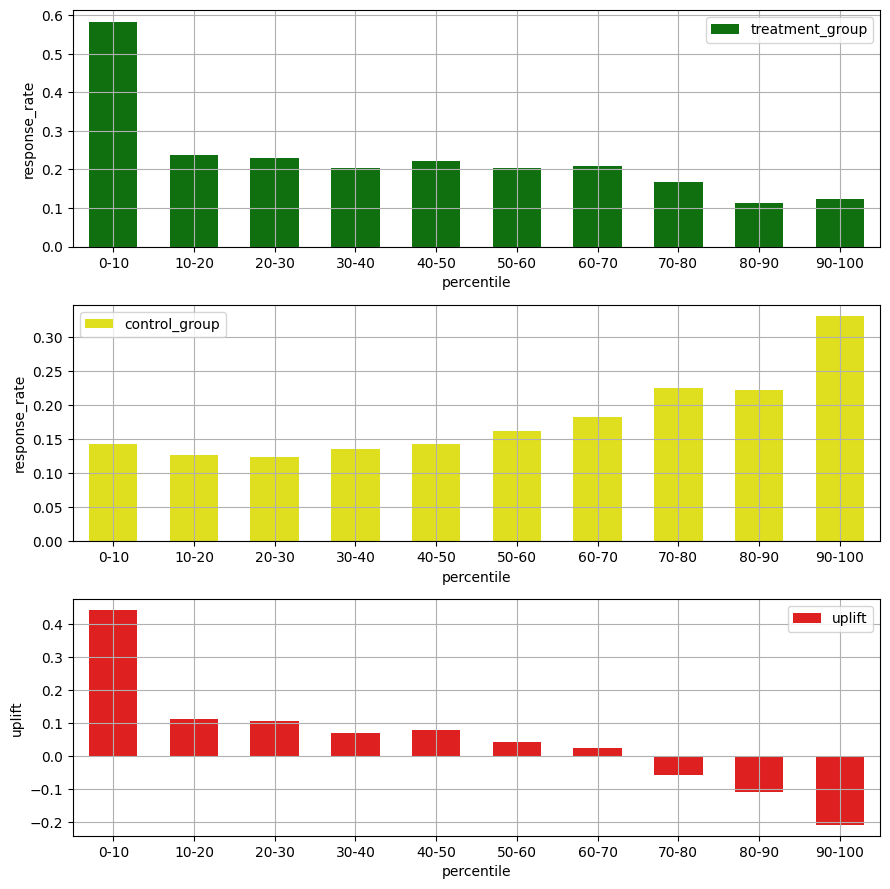

In [ ]:
plt.figure(figsize = (9,9))
plt.subplot(311)
sns.barplot(data = up_perc, x='percentile', y='response_rate_treatment', label = 'treatment_group', color = 'g', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('response_rate')
plt.grid()
plt.legend(loc = 'best')

plt.subplot(312)
sns.barplot(data = up_perc, x='percentile', y='response_rate_control', label = 'control_group', color = 'yellow', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('response_rate')
plt.grid()
plt.legend(loc = 'best')
plt.subplot(313)
sns.barplot(data = up_perc, x='percentile', y='uplift', label = 'uplift', color = 'r', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('uplift')
plt.grid()
plt.legend(loc = 'best')
plt.tight_layout()

# Две независимые модели

In [ ]:
estimator_trmnt1=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed)
estimator_ctrl1=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed)
two_models = TwoModels(
    estimator_trmnt=estimator_trmnt1,
    estimator_ctrl=estimator_ctrl1,
    method='vanilla'
)
cross_validate(two_models,
               X=X_train,
               y=y_train,
               scoring=uplift_scorer,
               return_estimator=True,
               cv=cv_gen,
               n_jobs=-1,
               fit_params={'treatment': treatment_train}
)

{'fit_time': array([376.80904555, 377.20457578, 221.28681278]),
 'score_time': array([0.3923521 , 0.43955278, 0.40348768]),
 'estimator': [TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x7c17370fb280>,
            estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x7c177c5a3070>),
  TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x7c17370f8940>,
            estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x7c1736f1ef80>),
  TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x7c17370fb7c0>,
            estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x7c1736f1e740>)],
 'test_score': array([0.24913163, 0.24025112, 0.25002322])}

In [ ]:
grid_params = {
    'estimator_trmnt__learning_rate': [ 0.1],
    'estimator_trmnt__depth': range(9, 10),
    'estimator_trmnt__iterations': [250],
    'estimator_ctrl__learning_rate': [ 0.1],
    'estimator_ctrl__depth': range(7, 8),
    'estimator_ctrl__iterations': [250]
}

grid_search = GridSearchCV(two_models,
                           param_grid=grid_params,
                           scoring=uplift_scorer,
                           n_jobs=-1,
                           cv=cv_gen,
                           return_train_score=True
                          )

grid_search = grid_search.fit(
    X=X_train,
    y=y_train,
    treatment=treatment_train
)

0:	learn: 0.6444525	total: 189ms	remaining: 47.2s
100:	learn: 0.3737627	total: 14.8s	remaining: 21.8s
200:	learn: 0.3587106	total: 29.3s	remaining: 7.13s
249:	learn: 0.3537438	total: 37.1s	remaining: 0us
0:	learn: 0.6552865	total: 270ms	remaining: 1m 7s
100:	learn: 0.4201347	total: 26.6s	remaining: 39.2s
200:	learn: 0.3918578	total: 54.9s	remaining: 13.4s
249:	learn: 0.3820855	total: 1m 7s	remaining: 0us


In [ ]:
print(f"Best qini score: {grid_search.best_score_:.4f}")
print(f"Best params: {grid_search.best_params_}")

Best qini score: 0.2498
Best params: {'estimator_ctrl__depth': 7, 'estimator_ctrl__iterations': 250, 'estimator_ctrl__learning_rate': 0.1, 'estimator_trmnt__depth': 9, 'estimator_trmnt__iterations': 250, 'estimator_trmnt__learning_rate': 0.1}


In [ ]:
two_models = TwoModels(
    estimator_trmnt=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed,depth=9,iterations=250,learning_rate=0.1),
    estimator_ctrl=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed, depth=7,iterations=250,learning_rate=0.1),
    method='vanilla'
)
two_models = two_models.fit(
    X_train, y_train, treatment_train,
    estimator_trmnt_fit_params={'plot': True},
    estimator_ctrl_fit_params={'plot': True}
)

tm_uplift = two_models.predict(X_test)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6444525	total: 147ms	remaining: 36.7s
100:	learn: 0.3737627	total: 14.6s	remaining: 21.6s
200:	learn: 0.3587106	total: 29.3s	remaining: 7.14s
249:	learn: 0.3537438	total: 37.1s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6552865	total: 294ms	remaining: 1m 13s
100:	learn: 0.4201347	total: 26.5s	remaining: 39.1s
200:	learn: 0.3918578	total: 52.7s	remaining: 12.8s
249:	learn: 0.3820855	total: 1m 5s	remaining: 0us


In [ ]:
#tm_uplift = grid_search.best_estimator_.predict(X_test)

# weighted average uplift
uplift_full_data = weighted_average_uplift(y_test, tm_uplift, treatment_test, bins=10)
print(f"average uplift на тестовой выборке: {uplift_full_data:.4f}")

average uplift на тестовой выборке: 0.0503


In [ ]:
tm_score_overall = uplift_at_k(y_true=y_test, uplift=tm_uplift, treatment=treatment_test, strategy='overall', k=0.3)
print(f'uplift@30% overall {tm_score_overall}')
tm_score_by_group = uplift_at_k(y_true=y_test, uplift=tm_uplift, treatment=treatment_test, strategy='overall', k=0.3)
print(f'uplift@30% overall {tm_score_by_group}')
models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score_by_group)

uplift@30% overall 0.2238443194257606
uplift@30% overall 0.2238443194257606


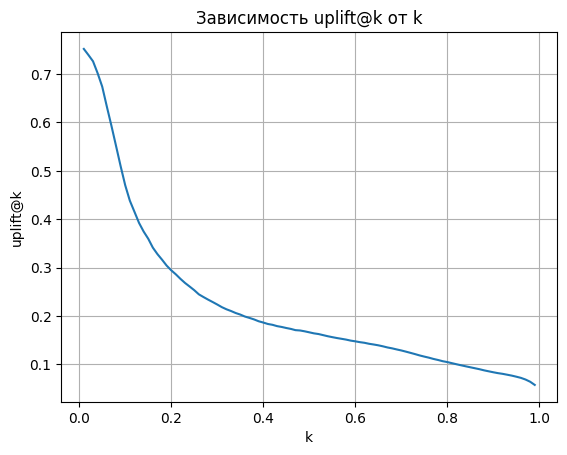

In [ ]:
values_uplift_k_solo = []
values_k = []
for k in np.arange(0.01,1,0.01):
  values_uplift_k_solo.append(uplift_at_k(y_test, tm_uplift, treatment_test, strategy='overall', k=k))
  values_k.append(k)

plt.plot(values_k, values_uplift_k_solo)
plt.title('Зависимость uplift@k от k')
plt.xlabel('k')
plt.ylabel('uplift@k')
plt.grid()
plt.show()

In [ ]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, tm_uplift, treatment_test)
print(f"Qini coefficient на тестовой выборке: {auqc:.4f}")

Qini coefficient на тестовой выборке: 0.2516


In [ ]:
# AUUC = area under Uplift curve
auuc = uplift_auc_score(y_test, tm_uplift, treatment_test)
print(f"Uplift coefficient на тестовой выборке: {auuc:.4f}")

Uplift coefficient на тестовой выборке: 0.1734


In [ ]:
# uplift_by_percentile
up_perc = uplift_by_percentile(y_test, tm_uplift, treatment_test,
                     strategy='overall',
                     total=False, std=True, bins=10).reset_index()
up_perc

,percentile,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
0,0-10,5960,6040,0.601846,0.131954,0.469892,0.006341,0.004355,0.007692
1,10-20,5984,6016,0.242313,0.122507,0.119806,0.005539,0.004227,0.006968
2,20-30,6028,5972,0.200730,0.116711,0.084019,0.005159,0.004155,0.006624
3,30-40,6072,5928,0.196640,0.120108,0.076532,0.005101,0.004222,0.006621
4,40-50,6019,5981,0.208673,0.122889,0.085783,0.005238,0.004245,0.006742
5,50-60,6030,5970,0.188723,0.133668,0.055055,0.005039,0.004404,0.006692
6,60-70,6039,5961,0.172380,0.156350,0.016030,0.004860,0.004704,0.006764
7,70-80,5951,6049,0.094774,0.159035,-0.064261,0.003797,0.004702,0.006044
8,80-90,6039,5961,0.097864,0.181849,-0.083985,0.003824,0.004996,0.006291
9,90-100,5951,6049,0.289195,0.545049,-0.255854,0.005877,0.006403,0.008691


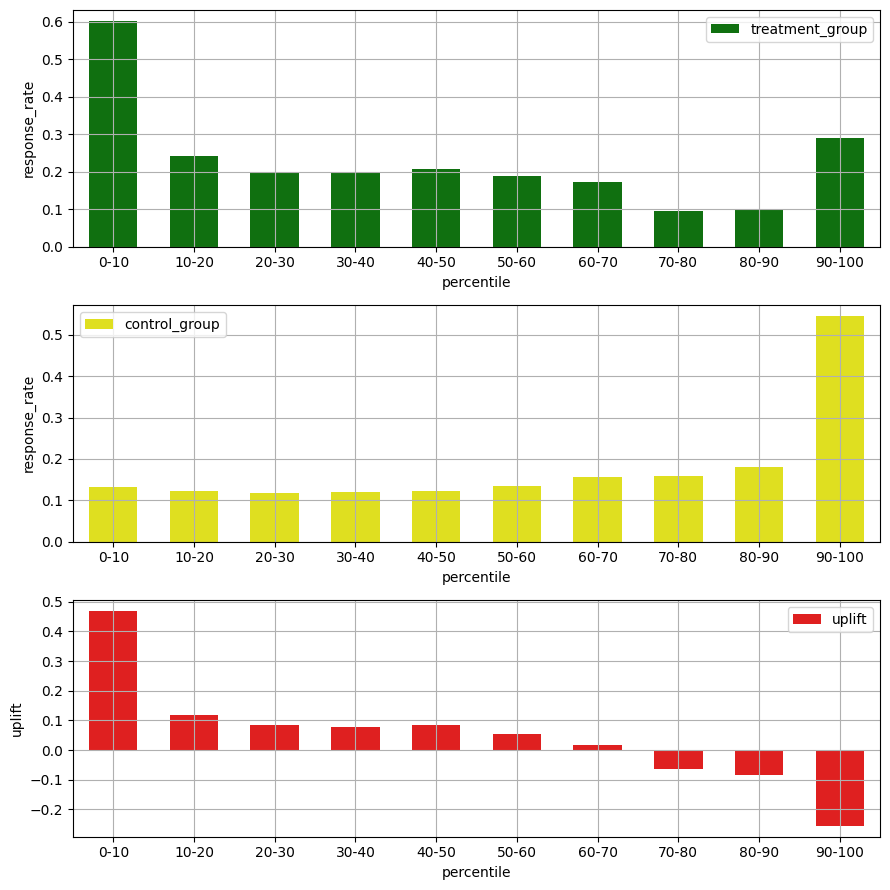

In [ ]:
plt.figure(figsize = (9,9))
plt.subplot(311)
sns.barplot(data = up_perc, x='percentile', y='response_rate_treatment', label = 'treatment_group', color = 'g', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('response_rate')
plt.grid()
plt.legend(loc = 'best')

plt.subplot(312)
sns.barplot(data = up_perc, x='percentile', y='response_rate_control', label = 'control_group', color = 'yellow', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('response_rate')
plt.grid()
plt.legend(loc = 'best')
plt.subplot(313)
sns.barplot(data = up_perc, x='percentile', y='uplift', label = 'uplift', color = 'r', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('uplift')
plt.grid()
plt.legend(loc = 'best')
plt.tight_layout()

# Две зависимые модели

In [ ]:
estimator_trmnt1=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed)
estimator_ctrl1=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed)
two_models_ctrl = TwoModels(
    estimator_trmnt=estimator_trmnt1,
    estimator_ctrl=estimator_ctrl1,
    method='ddr_control'
)
cross_validate(two_models_ctrl,
               X=X_train,
               y=y_train,
               scoring=uplift_scorer,
               return_estimator=True,
               cv=cv_gen,
               n_jobs=-1,
               fit_params={'treatment': treatment_train}
)

{'fit_time': array([433.80974007, 436.13466501, 211.23762035]),
 'score_time': array([0.66053438, 0.71287513, 0.37708807]),
 'estimator': [TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x78cddf9b0df0>,
            estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x78cddf9b3760>,
            method='ddr_control'),
  TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x78cddf9b19c0>,
            estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x78cddf9b26e0>,
            method='ddr_control'),
  TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x78cddf9b1900>,
            estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x78cddf9b1f00>,
            method='ddr_control')],
 'test_score': array([0.23862145, 0.23119642, 0.23774247])}

In [ ]:
grid_params = {
    'estimator_trmnt__learning_rate': [0.1],
    'estimator_trmnt__depth': range(9, 11),
    'estimator_trmnt__iterations': [ 350, 380],
    'estimator_ctrl__learning_rate': [ 0.1],
    'estimator_ctrl__depth': range(8, 10),
    'estimator_ctrl__iterations': [350, 380]
}

grid_search = GridSearchCV(two_models_ctrl,
                           param_grid=grid_params,
                           scoring=uplift_scorer,
                           n_jobs=-1,
                           cv=cv_gen,
                           return_train_score=True
                          )

grid_search = grid_search.fit(
    X=X_train,
    y=y_train,
    treatment=treatment_train
)

0:	learn: 0.6411414	total: 470ms	remaining: 2m 43s
100:	learn: 0.3580031	total: 25.4s	remaining: 1m 2s
200:	learn: 0.3371402	total: 49.9s	remaining: 37s
300:	learn: 0.3203744	total: 1m 12s	remaining: 11.8s
349:	learn: 0.3134496	total: 1m 24s	remaining: 0us
0:	learn: 0.6461663	total: 666ms	remaining: 3m 52s
100:	learn: 0.3877042	total: 49.6s	remaining: 2m 2s
200:	learn: 0.3591698	total: 1m 36s	remaining: 1m 11s
300:	learn: 0.3345697	total: 2m 24s	remaining: 23.5s
349:	learn: 0.3232464	total: 2m 50s	remaining: 0us


In [ ]:
print(f"Best qini score: {grid_search.best_score_:.4f}")
print(f"Best params: {grid_search.best_params_}")

Best qini score: 0.2407
Best params: {'estimator_ctrl__depth': 9, 'estimator_ctrl__iterations': 350, 'estimator_ctrl__learning_rate': 0.1, 'estimator_trmnt__depth': 10, 'estimator_trmnt__iterations': 350, 'estimator_trmnt__learning_rate': 0.1}


In [ ]:
two_models_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed,depth=10,iterations=350,learning_rate=0.1),
    estimator_ctrl=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed,depth=9,iterations=350,learning_rate=0.1),
    method='ddr_control'
)
two_models_ctrl = two_models_ctrl.fit(
    X_train, y_train, treatment_train,
    estimator_trmnt_fit_params={'plot': True},
    estimator_ctrl_fit_params={'plot': True}
)

tmc_uplift = two_models_ctrl.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6411414	total: 417ms	remaining: 2m 25s
100:	learn: 0.3580031	total: 31.7s	remaining: 1m 18s
200:	learn: 0.3371402	total: 1m 8s	remaining: 51s
300:	learn: 0.3203744	total: 1m 36s	remaining: 15.6s
349:	learn: 0.3134496	total: 1m 50s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6461663	total: 418ms	remaining: 2m 25s
100:	learn: 0.3877042	total: 1m 7s	remaining: 2m 45s
200:	learn: 0.3591698	total: 2m 1s	remaining: 1m 29s
300:	learn: 0.3345697	total: 2m 52s	remaining: 28.2s
349:	learn: 0.3232464	total: 3m 17s	remaining: 0us


In [ ]:
#tmc_uplift = grid_search.best_estimator_.predict(X_test)

# weighted average uplift
uplift_full_data = weighted_average_uplift(y_test, tmc_uplift, treatment_test, bins=10)
print(f"average uplift на тестовой выборке: {uplift_full_data:.4f}")

average uplift на тестовой выборке: 0.0500


In [ ]:
tmc_score_overall = uplift_at_k(y_true=y_test, uplift=tmc_uplift, treatment=treatment_test, strategy='overall', k=0.3)
print(f'uplift@30% overall {tmc_score_overall}')
tmc_score_by_group = uplift_at_k(y_true=y_test, uplift=tmc_uplift, treatment=treatment_test, strategy='overall', k=0.3)
print(f'uplift@30% overall {tmc_score_by_group}')
models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tmc_score_by_group)

uplift@30% overall 0.21375989240151635
uplift@30% overall 0.21375989240151635


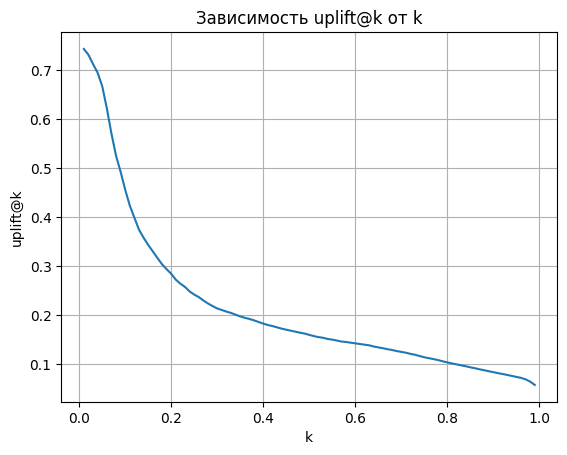

In [ ]:
values_uplift_k_solo = []
values_k = []
for k in np.arange(0.01,1,0.01):
  values_uplift_k_solo.append(uplift_at_k(y_test, tmc_uplift, treatment_test, strategy='overall', k=k))
  values_k.append(k)

plt.plot(values_k, values_uplift_k_solo)
plt.title('Зависимость uplift@k от k')
plt.xlabel('k')
plt.ylabel('uplift@k')
plt.grid()
plt.show()

In [ ]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, tmc_uplift, treatment_test)
print(f"Qini coefficient на тестовой выборке: {auqc:.4f}")

Qini coefficient на тестовой выборке: 0.2407


In [ ]:
# AUUC = area under Uplift curve
auuc = uplift_auc_score(y_test, tmc_uplift, treatment_test)
print(f"Uplift coefficient на тестовой выборке: {auuc:.4f}")

Uplift coefficient на тестовой выборке: 0.1664


In [ ]:
# uplift_by_percentile
up_perc = uplift_by_percentile(y_test, tmc_uplift, treatment_test,
                     strategy='overall',
                     total=False, std=True, bins=10).reset_index()
up_perc

,percentile,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
0,0-10,5934,6066,0.659083,0.203099,0.455984,0.006153,0.005165,0.008034
1,10-20,5924,6076,0.288994,0.176103,0.112891,0.005889,0.004887,0.007653
2,20-30,6076,5924,0.210171,0.132849,0.077322,0.005227,0.004410,0.006839
3,30-40,6026,5974,0.217059,0.125544,0.091515,0.005311,0.004287,0.006825
4,40-50,6064,5936,0.201847,0.132412,0.069435,0.005154,0.004399,0.006776
5,50-60,6058,5942,0.191812,0.134635,0.057178,0.005059,0.004428,0.006723
6,60-70,6008,5992,0.172603,0.152370,0.020233,0.004875,0.004643,0.006732
7,70-80,5913,6087,0.100288,0.149170,-0.048883,0.003906,0.004566,0.006009
8,80-90,6082,5918,0.083854,0.158162,-0.074308,0.003554,0.004743,0.005927
9,90-100,5988,6012,0.170007,0.427312,-0.257305,0.004854,0.006380,0.008017


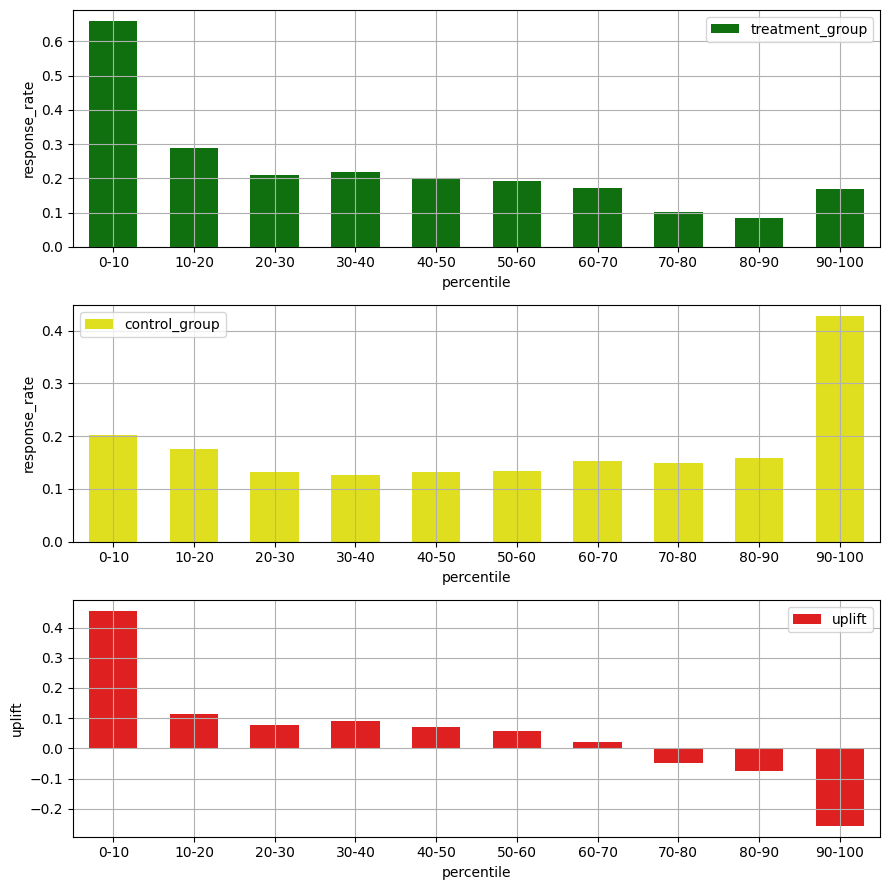

In [ ]:
plt.figure(figsize = (9,9))
plt.subplot(311)
sns.barplot(data = up_perc, x='percentile', y='response_rate_treatment', label = 'treatment_group', color = 'g', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('response_rate')
plt.grid()
plt.legend(loc = 'best')

plt.subplot(312)
sns.barplot(data = up_perc, x='percentile', y='response_rate_control', label = 'control_group', color = 'yellow', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('response_rate')
plt.grid()
plt.legend(loc = 'best')
plt.subplot(313)
sns.barplot(data = up_perc, x='percentile', y='uplift', label = 'uplift', color = 'r', width = 0.6)
plt.xlabel('percentile')
plt.ylabel('uplift')
plt.grid()
plt.legend(loc = 'best')
plt.tight_layout()

In [ ]:
estimator_trmnt1=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed)
estimator_ctrl1=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed)
two_models_trtmt = TwoModels(
    estimator_trmnt=estimator_trmnt1,
    estimator_ctrl=estimator_ctrl1,
    method='ddr_treatment'
)
cross_validate(two_models_trtmt,
               X=X_train,
               y=y_train,
               scoring=uplift_scorer,
               return_estimator=True,
               cv=cv_gen,
               n_jobs=-1,
               fit_params={'treatment': treatment_train}
)

{'fit_time': array([363.42316437, 364.28244376, 213.00512362]),
 'score_time': array([0.69017243, 0.49172544, 0.26046062]),
 'estimator': [TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x79afa9167df0>,
            estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x79afa8fe5ab0>,
            method='ddr_treatment'),
  TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x79afa9167cd0>,
            estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x79afa8fe4040>,
            method='ddr_treatment'),
  TwoModels(estimator_ctrl=<catboost.core.CatBoostClassifier object at 0x79afa9167c70>,
            estimator_trmnt=<catboost.core.CatBoostClassifier object at 0x79afa8fe5060>,
            method='ddr_treatment')],
 'test_score': array([0.24847335, 0.24048563, 0.24546197])}

In [ ]:
grid_params = {
    'estimator_trmnt__learning_rate': [0.1],
    'estimator_trmnt__depth': range(9, 11),
    'estimator_trmnt__iterations': [ 380, 400],
    'estimator_ctrl__learning_rate': [ 0.1],
    'estimator_ctrl__depth': range(8, 11),
    'estimator_ctrl__iterations': [350, 380]
}

grid_search = GridSearchCV(two_models_trtmt,
                           param_grid=grid_params,
                           scoring=uplift_scorer,
                           n_jobs=-1,
                           cv=cv_gen,
                           return_train_score=True
                          )

grid_search = grid_search.fit(
    X=X_train,
    y=y_train,
    treatment=treatment_train
)

0:	learn: 0.6552865	total: 787ms	remaining: 5m 14s
100:	learn: 0.4201347	total: 27s	remaining: 1m 19s
200:	learn: 0.3918578	total: 53.1s	remaining: 52.5s
300:	learn: 0.3731136	total: 1m 17s	remaining: 25.4s
399:	learn: 0.3572968	total: 1m 44s	remaining: 0us
0:	learn: 0.6379580	total: 181ms	remaining: 1m 8s
100:	learn: 0.3679375	total: 18.6s	remaining: 51.4s
200:	learn: 0.3505804	total: 38s	remaining: 33.8s
300:	learn: 0.3384768	total: 55.5s	remaining: 14.6s
379:	learn: 0.3299989	total: 1m 9s	remaining: 0us


In [ ]:
print(f"Best qini score: {grid_search.best_score_:.4f}")
print(f"Best params: {grid_search.best_params_}")

Best qini score: 0.2470
Best params: {'estimator_ctrl__depth': 8, 'estimator_ctrl__iterations': 380, 'estimator_ctrl__learning_rate': 0.1, 'estimator_trmnt__depth': 9, 'estimator_trmnt__iterations': 400, 'estimator_trmnt__learning_rate': 0.1}


In [ ]:
two_models_trtmt = TwoModels(
    estimator_trmnt=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed,depth=9,iterations=400,learning_rate=0.1),
    estimator_ctrl=CatBoostClassifier(verbose = 100, thread_count=1, random_state=seed,depth=8,iterations=380,learning_rate=0.1),
    method='ddr_treatment'
)
two_models_trtmt = two_models_trtmt.fit(
    X_train, y_train, treatment_train,
    estimator_trmnt_fit_params={'plot': True},
    estimator_ctrl_fit_params={'plot': True}
)

tmt_uplift = two_models_trtmt.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6552865	total: 282ms	remaining: 1m 52s
100:	learn: 0.4201347	total: 25.7s	remaining: 1m 16s
200:	learn: 0.3918578	total: 51.2s	remaining: 50.7s
300:	learn: 0.3731136	total: 1m 16s	remaining: 25.1s
399:	learn: 0.3572968	total: 1m 40s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6379580	total: 174ms	remaining: 1m 6s
100:	learn: 0.3679375	total: 17.9s	remaining: 49.5s
200:	learn: 0.3505804	total: 37s	remaining: 32.9s
300:	learn: 0.3384768	total: 54.3s	remaining: 14.3s
379:	learn: 0.3299989	total: 1m 8s	remaining: 0us


In [ ]:
#tmt_uplift = grid_search.best_estimator_.predict(X_test)

# weighted average uplift
uplift_full_data = weighted_average_uplift(y_test, tmt_uplift, treatment_test, bins=10)
print(f"average uplift на тестовой выборке: {uplift_full_data:.4f}")

average uplift на тестовой выборке: 0.0506


In [ ]:
tmt_score_overall = uplift_at_k(y_true=y_test, uplift=tmt_uplift, treatment=treatment_test, strategy='overall', k=0.3)
print(f'uplift@30% overall {tmt_score_overall}')
tmt_score_by_group = uplift_at_k(y_true=y_test, uplift=tmt_uplift, treatment=treatment_test, strategy='overall', k=0.3)
print(f'uplift@30% overall {tmt_score_by_group}')
models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tmt_score_by_group)

uplift@30% overall 0.21996998036003595
uplift@30% overall 0.21996998036003595


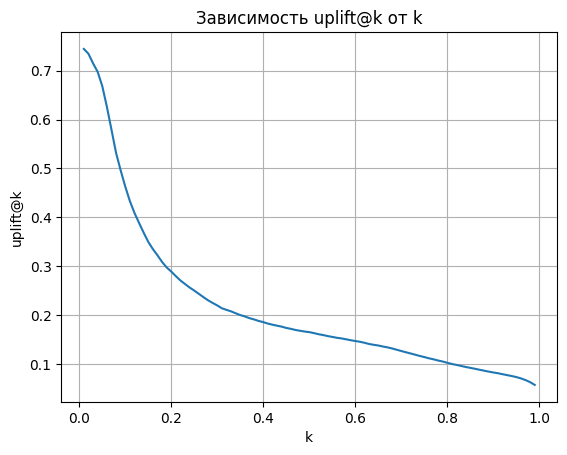

In [ ]:
values_uplift_k_solo = []
values_k = []
for k in np.arange(0.01,1,0.01):
  values_uplift_k_solo.append(uplift_at_k(y_test, tmt_uplift, treatment_test, strategy='overall', k=k))
  values_k.append(k)

plt.plot(values_k, values_uplift_k_solo)
plt.title('Зависимость uplift@k от k')
plt.xlabel('k')
plt.ylabel('uplift@k')
plt.grid()
plt.show()

In [ ]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, tmt_uplift, treatment_test)
print(f"Qini coefficient на тестовой выборке: {auqc:.4f}")

Qini coefficient на тестовой выборке: 0.2464


In [ ]:
# AUUC = area under Uplift curve
auuc = uplift_auc_score(y_test, tmt_uplift, treatment_test)
print(f"Uplift coefficient на тестовой выборке: {auuc:.4f}")

Uplift coefficient на тестовой выборке: 0.1699


In [ ]:
# uplift_by_percentile
up_perc = uplift_by_percentile(y_test, tmt_uplift, treatment_test,
                     strategy='overall',
                     total=False, std=True, bins=10).reset_index()
up_perc

,percentile,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
0,0-10,5931,6069,0.590120,0.126874,0.463245,0.006386,0.004272,0.007683
1,10-20,6019,5981,0.230271,0.112189,0.118082,0.005427,0.004081,0.006790
2,20-30,6012,5988,0.202262,0.120073,0.082189,0.005181,0.004201,0.006670
3,30-40,6030,5970,0.201824,0.117420,0.084404,0.005169,0.004166,0.006639
4,40-50,6061,5939,0.204587,0.120054,0.084533,0.005182,0.004218,0.006681
5,50-60,6041,5959,0.192518,0.135929,0.056589,0.005073,0.004440,0.006741
6,60-70,5960,6040,0.164094,0.160762,0.003332,0.004797,0.004726,0.006734
7,70-80,6009,5991,0.088534,0.154565,-0.066031,0.003665,0.004670,0.005936
8,80-90,6074,5926,0.094337,0.168073,-0.073736,0.003750,0.004857,0.006137
9,90-100,5936,6064,0.327999,0.572889,-0.244891,0.006094,0.006352,0.008802


In [ ]:
df1 = pd.DataFrame(models_results)
df1

,approach,uplift@30%
0,SoloModel,0.215352
1,ClassTransformationModel,0.218084
2,TwoModels,0.223844
3,TwoModels_ddr_control,0.213760
4,TwoModels_ddr_treatment,0.219970


Лучший результат у двух независимых моделей

# feature_importances

In [ ]:
importances=grid_search.best_estimator_.estimator_ctrl.feature_importances_

In [ ]:
importances

array([ 0.12470498,  0.16164989,  9.62094738,  0.12448771,  0.14383412,
        4.92557092,  0.12698733,  0.04394822,  0.04625132,  1.82795573,
        5.03013759,  2.4209634 ,  0.07950818,  0.15711984,  3.17856542,
        0.08793387,  3.62303055,  0.16069301,  9.27069298,  0.1346779 ,
        2.49241798,  0.05876629,  0.06946592,  0.11171907,  2.50923272,
        0.1588363 ,  0.14306796,  2.4977567 ,  0.11521357,  0.19098645,
        0.0658008 ,  1.43003683, 10.06548742,  0.1896105 ,  0.14443427,
        0.0359579 ,  0.1205887 ,  5.87194706,  3.44589326,  0.07087448,
       10.47626355,  1.50266154,  3.25928458,  0.16068263,  0.03348305,
        0.15986957,  4.86802199,  5.73316083,  2.5797564 ,  0.14906134])

In [ ]:
# Важность признаков оценим с помощью feature_importances_
feature_imp = pd.DataFrame(
     {'Признак' :X_train.columns,
        'Важность':grid_search.best_estimator_.estimator_ctrl.feature_importances_
     }).sort_values(by ='Важность',  ascending = False)
feature_imp

,Признак,Важность
40,X_41,10.476264
32,X_33,10.065487
2,X_3,9.620947
18,X_19,9.270693
37,X_38,5.871947
...,...,...
21,X_22,0.058766
8,X_9,0.046251
7,X_8,0.043948
35,X_36,0.035958


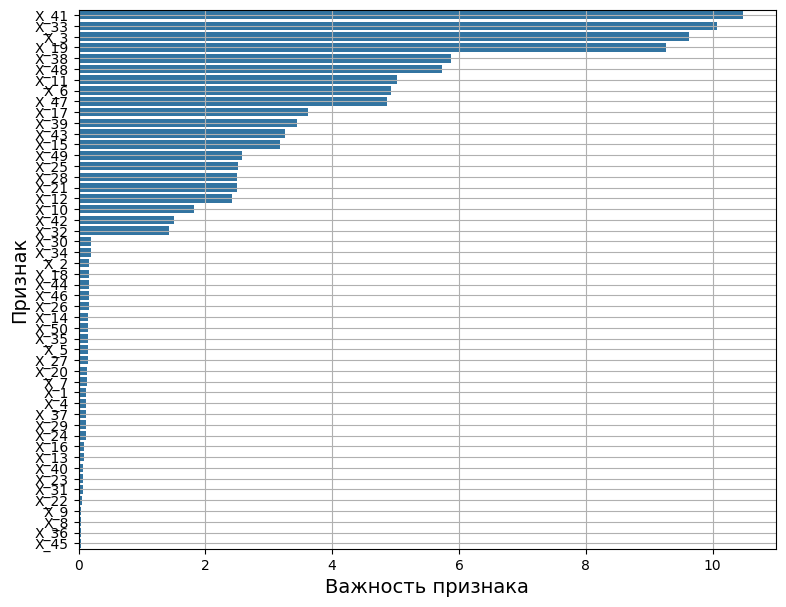

In [ ]:
# Визуализируем важность признаков
plt.figure(figsize=(9, 7))

sns.barplot(x=feature_imp['Важность'],y=feature_imp['Признак'])

plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()

# SHAP

In [ ]:
pip install shap

In [ ]:
import shap

In [ ]:
# SHAP Explainer
explainer = shap.Explainer(grid_search.best_estimator_.estimator_ctrl)
shap_values = explainer(X_test)

In [ ]:
# Вычисляем значения Шепли
explainer =shap.TreeExplainer(grid_search.best_estimator_.estimator_ctrl)

shap_values =explainer.shap_values(X_test)

shap_val =explainer(X_test)

In [ ]:
shap_val

.values =
array([[ 0.00206534, -0.01064013,  0.24371848, ...,  0.09546982,
        -0.05327524,  0.00145436],
       [-0.00289991, -0.00232704,  0.25104842, ...,  0.23132409,
         0.01093989,  0.00189832],
       [-0.00379459,  0.00315263,  0.23495211, ...,  0.04001224,
        -0.04437642, -0.0019637 ],
       ...,
       [-0.00070277, -0.0046145 ,  0.24083598, ...,  0.09648257,
        -0.04475935,  0.00418738],
       [ 0.00162532, -0.00084409,  0.31591873, ...,  0.11900755,
        -0.00811109,  0.00209449],
       [-0.00056737,  0.00174159, -0.56568148, ...,  0.13410868,
         0.06938195,  0.00319189]])

.base_values =
array([-1.69531782, -1.69531782, -1.69531782, ..., -1.69531782,
       -1.69531782, -1.69531782])

.data =
array([[  0.52437429,  -1.93074194,   5.67972589, ...,  -4.08633699,
        161.39331173, -19.38873454],
       [-60.07042727,  -0.49289248, -14.48525745, ..., 105.33116754,
         34.19335492,  12.39576459],
       [-66.54013008,   1.0779115 ,  10.35

In [ ]:
shap_values.shape

(120000, 50)

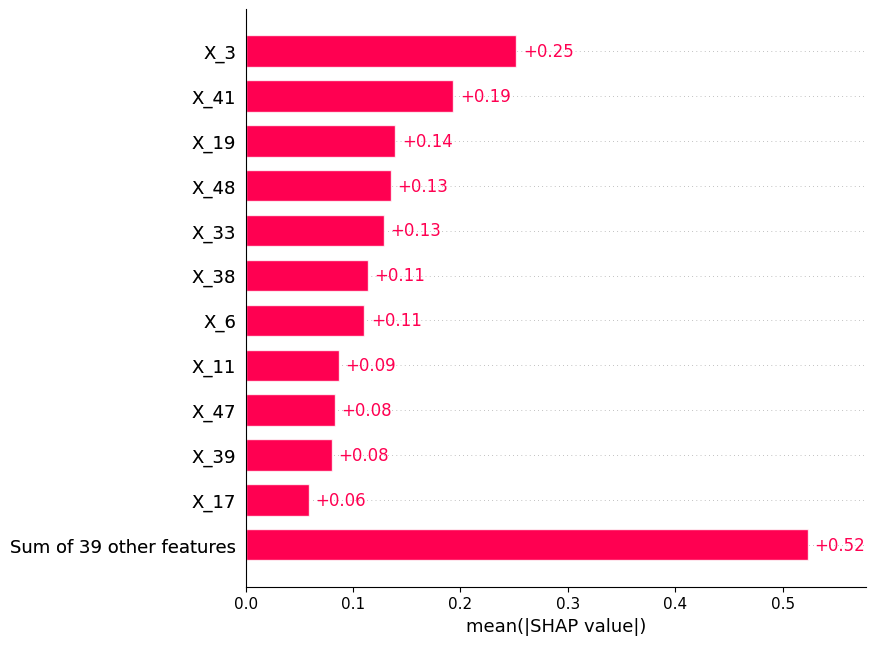

In [ ]:
# Построим график общей значимости признаков :
shap.plots.bar(shap_val,max_display=12)

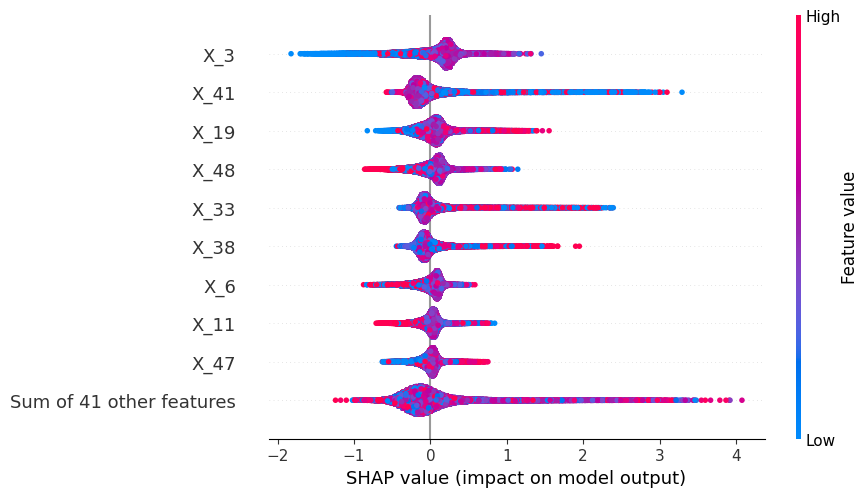

In [ ]:
# Посмотрим, как признаки влияют на каждое предсказание модели:
shap.plots.beeswarm(shap_val)

Вот как читать этот график:

Негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0, а положительные справа — к классу 1.
Чем толще линия по вертикали, тем больше наблюдений сгруппированы вместе: у них близкие значения Шепли. Это значит, что модель уверенно присваивает SHAP-значения, с учётом закономерностей в данных.
Цвет точки отражает значения каждого признака объекта: чем краснее объект, тем больше признак, указанный на оси Y.